In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [6]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.456985898908219

In [7]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.371867598400412

In [8]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [9]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if 'rail_short' in sm.pt_los['route_type']:
    sm.pt_los['route_type_disagg'] = sm.pt_los['route_type'].copy()
sm.pt_los['route_type'] = sm.pt_los['route_type'].map(type_dict)

In [10]:
sm.pt_los.sample()

,access_time,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,price,route_type,route_types,time,waiting_time
index,,,,,,,,,,,,,
475333,2440,DE922,948,7335,458773,"[bus_1211782, bus_1211783, bus_1819087, bus_15...",7,DED43,57.0,air,"[bus, air]",4.895556,6900


In [11]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

713901

In [12]:
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [13]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

707120

In [14]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

## Prepare the logit model

Load parameters and generate LoS columns

In [15]:
# Transport demand segments: the cartesian product of
# trip purposes and car ownership
#segments_tuple = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
# Convert tuple segments to strings in order to prevent issues
#segments = [str(seg) for seg in segments_tuple]
# Just trip purposes
segments =  ['Fz'+str(p) for p in [1,2,3,4,6]]

In [16]:
# Create a column for generalised cost, see cal20
#vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT', 'rail': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
#for s in segments_tuple:
#    sm.los[(str(s), 'gc')] = sm.los['time'] + [c / vot[s[0], 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
#        if m!='walk' else 0 for c,d,m in zip(
#            sm.los['price'], sm.los['length'], sm.los['route_type'])]

"# Take the same VoT for every segment\nsm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]\n    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]\n"

In [17]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))

In [18]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,
rail,root,root,root,root,root
bus,root,root,root,root,root
air,root,root,root,root,root
car,root,root,root,root,root
walk,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN


In [19]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(segments))]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,1,1,1,1,1
bus,1,1,1,1,1
air,1,1,1,1,1
car,1,1,1,1,1
walk,1,1,1,1,1
root,1,1,1,1,1


In [20]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6
rail,-1.861813,-0.201161,-2.714542,-2.611749,-2.589026
bus,-3.687939,-0.332885,-3.514192,-3.920685,-3.521607
air,-6.151631,-5.351026,-3.119983,-3.334793,-2.690224
car,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-5.757532,-2.848011,-4.193931,-4.851682,-4.316782
root,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Performance attributes for mode choice
perf_attrs = [(s, 't') for s in segments]

In [22]:
# Beta parameters from calibration data
# IMPORTANT: mind the unit conversion
sm.utility_values = pd.DataFrame({s: [0 for _ in perf_attrs] for s in segments},
                                 index=[str(a) for a in perf_attrs])
sm.utility_values.loc['c'] = [params_est[segments.index(s)].loc['b_c', 'Value']
                              for s in segments]
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a in perf_attrs:
    sm.utility_values.loc[str(a), a[0]] = params_est[segments.index(a[0])].loc['b_t', 'Value']
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6
"('Fz1', 't')",-0.151069,0.000000,0.000000,0.00000,0.000000
"('Fz2', 't')",0.000000,-0.053636,0.000000,0.00000,0.000000
"('Fz3', 't')",0.000000,0.000000,-0.086355,0.00000,0.000000
"('Fz4', 't')",0.000000,0.000000,0.000000,-0.48841,0.000000
"('Fz6', 't')",0.000000,0.000000,0.000000,0.00000,-0.135318
c,-0.097024,-0.053539,-0.056959,0.00000,-0.024921
mode_utility,1.000000,1.000000,1.000000,1.00000,1.000000


In [23]:
# Generate damped cost (see cal20)
c = params['estimation'].to_dict()
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    return (beta*theta[0]*np.power(np.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*np.power(np.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*np.power(np.log(x),Q-3+1) + alpha[2]) * (x>=c2)

# Apply the spline function
for s in segments:
#    for a in perf_attrs:
#        sm.los[a] = [spline(gc, beta) for gc in sm.los[(s, 'gc')]]
    c1 = c['c1_time_'+s[-1]]
    c2 = c['c2_time_'+s[-1]]
    beta = sm.utility_values.loc[str((s, 't')), s]
    sm.los[str((s, 't'))] = [spline(t, beta, c1, c2) for t in sm.los['time']]
sm.los['c'] = sm.los['price']

In [24]:
# Make beta_t one because it is now included in the LoS attribute 't'
for a in perf_attrs:
    sm.utility_values.loc[str(a), a[0]] = 1

## Mode Choice

In [25]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


In [26]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


In [27]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(801975, 9)
(801975, 9)


In [28]:
sm.probabilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
26460,DE24D,DE244,Fz1,1,0.003834,0.893321,0.0,0.000000,0.102844
21554,DE27C,DEB32,Fz6,1,0.000000,0.864050,0.0,0.029136,0.106814
26545,DE27D,DE258,Fz1,1,0.000000,0.934475,0.0,0.000000,0.065525


In [29]:
sm.utilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
67204,DEB3E,DE94H,Fz6,-1.231607,-inf,-1.283616,-6.504437,-inf,-4.320553
61824,DEB36,DEF03,Fz6,-1.387747,-inf,-1.453773,-inf,-inf,-4.138296
22112,DE262,DE12A,Fz3,-3.139679,-inf,-3.169321,-inf,-7.328282,-7.405568


In [30]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(Fz1, utility)","(Fz2, utility)","(Fz3, utility)","(Fz4, utility)","(Fz6, utility)","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
659757,600,NaN,DEA1B,NaT,5228,138783,"[rl_93250, rl_30016, rl_115957, rl_308766, rl_...",0.0,0,DEA2C,...,-1.026891,-1.66116,-2.365034,0.0,-0.381842,0.88737,0.450443,0.936154,0.806422,0.847902


In [31]:
# Validate that probabilities sum up to one
od = sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1)
print(od.mean())
print(od.max())
print(od.min())

1.0
1.0000000000000002
0.9999999999999998


## Save model

In [32]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:11<00:00,  3.45it/s]


In [33]:
# Save LoS table
sm.los.drop(list(sm.utility_values.index), axis=1, errors='ignore', inplace=True)
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.91it/s]


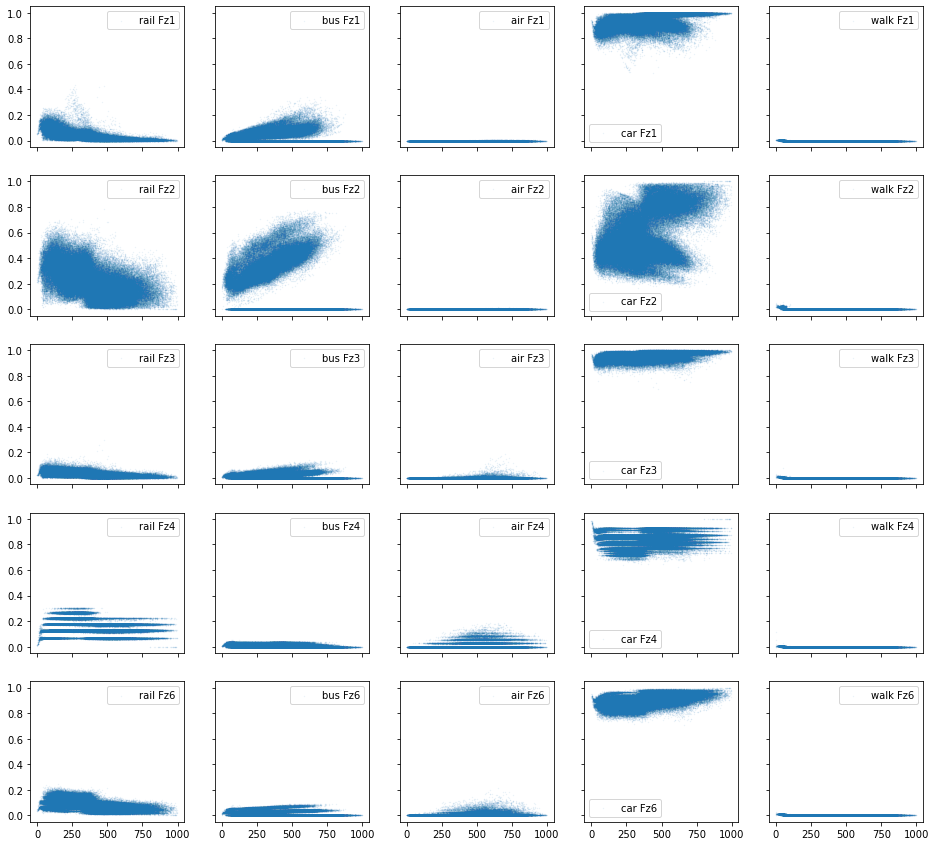

In [34]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                    on=['origin', 'destination'], how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(16,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()

In [41]:
sm.utilities = None
sm.probabilities = None

### Save composite generalised cost
For sequential destination choice modelling

In [42]:
# Prepare beta values
beta_dict = {}
for s in segments:
    beta_dict.update({s: {'c': params_est[segments.index(s)].loc['b_c', 'Value'],
                          't': params_est[segments.index(s)].loc['b_t', 'Value']}
                     })

In [77]:
# Formula to calculate composite generalised cost
def composite_cost(od, beta, seg):
    # Given a DataFrame of cost attribute values and mode column
    # with MultiIndex [origin, destination, route_type]
    return od#.unstack(level=2)
    exp_sum = np.exp(np.multiply(od.unstack(level=2), -beta)).sum(axis=1)
    cgc = -1/beta * np.log(exp_sum)
    return pd.DataFrame({'CGC': cgc, 'segment': seg})

In [51]:
# Generate time DataFrame
t = pd.DataFrame(index=sm.los.index)
for s in segments:
    c1 = c['c1_time_'+s[-1]]
    c2 = c['c2_time_'+s[-1]]
    beta = beta_dict[s]['t']
    t[s] = [spline(t, beta, c1, c2) for t in sm.los['time']]
t[['origin', 'destination', 'route_type']] = sm.los[['origin', 'destination', 'route_type']]

In [78]:
dfs = []
for s in segments:
    dfs.append(t.sort_values(['origin', 'destination']).iloc[:10][[s, 'origin', 'destination', 'route_type']].groupby(
        ['origin', 'destination', 'route_type'])[s].apply(composite_cost, 1, s))
df = pd.concat(dfs)

In [79]:
df

0         0.000566
1         0.005412
2         0.023220
552838    0.000000
553519    0.047710
3         0.000842
4         0.000000
5         0.021430
6         0.018703
552606    0.000000
0        -0.714613
1        -0.610673
2        -0.487831
552838   -0.896469
553519   -0.401170
3        -0.701507
4        -1.259606
5        -0.496262
6        -0.510053
552606   -0.827926
0        -1.150542
1        -0.983197
2        -0.785418
552838   -1.443334
553519   -0.645892
3        -1.129441
4        -2.027991
5        -0.798992
6        -0.821196
552606   -1.332978
0         0.001831
1         0.017498
2         0.075071
552838    0.000000
553519    0.154250
3         0.002724
4         0.000000
5         0.069283
6         0.060468
552606    0.000000
0        -0.112182
1        -0.091521
2        -0.047958
552838   -0.118080
553519   -0.004747
3        -0.110395
4        -0.118080
5        -0.051610
6        -0.057375
552606   -0.118080
dtype: float64

In [ ]:
# Save composite time cost
df.to_csv(output_path + 'mode_choice_od_cgc_time.csv')

In [ ]:
# Same for price attribute
c = pd.DataFrame(index=sm.los.index)
# Only for segments where price is relevant to mode choice
segs = [s for s in segments if beta_dict[s]['c']!=0]
for s in segs:
    c[s] = sm.los['c']
c[['origin', 'destination', 'route_type']] = sm.los[['origin', 'destination', 'route_type']]

In [ ]:
# Save composite price cost
df.to_csv(output_path + 'mode_choice_od_cgc_price.csv')